# DataTables, Indexes, Pandas, and Seaborn

## Some useful (free) resources

Introductory:

* [Getting started with Python for research](https://github.com/TiesdeKok/LearnPythonforResearch), a gentle introduction to Python in data-intensive research.

* [A Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/index.html), by Jake VanderPlas, another quick Python intro (with notebooks).

Core Pandas/Data Science books:

* [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/), by Jake VanderPlas.

* [Python for Data Analysis, 2nd Edition](http://proquest.safaribooksonline.com/book/programming/python/9781491957653), by  Wes McKinney, creator of Pandas. [Companion Notebooks](https://github.com/wesm/pydata-book)

* [Effective Pandas](https://github.com/TomAugspurger/effective-pandas), a book by Tom Augspurger, core Pandas developer.


Complementary resources:

* [An introduction to "Data Science"](https://github.com/stefanv/ds_intro), a collection of Notebooks by BIDS' [Stéfan Van der Walt](https://bids.berkeley.edu/people/st%C3%A9fan-van-der-walt).

* [Effective Computation in Physics](http://proquest.safaribooksonline.com/book/physics/9781491901564), by Kathryn D. Huff; Anthony Scopatz. [Notebooks to accompany the book](https://github.com/physics-codes/seminar). Don't be fooled by the title, it's a great book on modern computational practices with very little that's physics-specific.


OK, let's load and configure some of our core libraries (as an aside, you can find a nice visual gallery of available matplotlib sytles [here](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html)).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

## Getting the Data

https://www.ssa.gov/OACT/babynames/index.html

https://www.ssa.gov/data

As we saw before, we can download data from the internet with Python, and do so only if needed:

In [2]:
import requests
from pathlib import Path

namesbystate_path = Path('namesbystate.zip')
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'

if not namesbystate_path.exists():
    print('Downloading...', end=' ')
    resp = requests.get(data_url)
    with namesbystate_path.open('wb') as f:
        f.write(resp.content)
    print('Done!')

Downloading... Done!


Let's use Python to understand how this data is laid out:

In [3]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')
print([f.filename for f in zf.filelist])

['DC.TXT', 'DE.TXT', 'FL.TXT', 'GA.TXT', 'HI.TXT', 'IA.TXT', 'ID.TXT', 'IL.TXT', 'IN.TXT', 'KS.TXT', 'KY.TXT', 'LA.TXT', 'MA.TXT', 'MD.TXT', 'ME.TXT', 'MI.TXT', 'MN.TXT', 'MO.TXT', 'MS.TXT', 'MT.TXT', 'NC.TXT', 'ND.TXT', 'NE.TXT', 'NH.TXT', 'NJ.TXT', 'NM.TXT', 'NV.TXT', 'NY.TXT', 'OH.TXT', 'OK.TXT', 'OR.TXT', 'PA.TXT', 'RI.TXT', 'SC.TXT', 'SD.TXT', 'TN.TXT', 'TX.TXT', 'UT.TXT', 'VA.TXT', 'VT.TXT', 'WA.TXT', 'WI.TXT', 'WV.TXT', 'WY.TXT', 'AK.TXT', 'AL.TXT', 'AR.TXT', 'AZ.TXT', 'CA.TXT', 'CO.TXT', 'CT.TXT', 'StateReadMe.pdf']


We can pull the PDF readme to view it, but let's operate with the rest of the data in its compressed state:

In [4]:
zf.extract('StateReadMe.pdf')

'/Users/weiwzhang/sp18-dev/lectures/lec03/StateReadMe.pdf'

Let's have a look at the California data, it should give us an idea about the structure of the whole thing:

In [5]:
ca_name = 'CA.TXT'
with zf.open(ca_name) as f:
    for i in range(10):
        print(f.readline().rstrip().decode())

CA,F,1910,Mary,295
CA,F,1910,Helen,239
CA,F,1910,Dorothy,220
CA,F,1910,Margaret,163
CA,F,1910,Frances,134
CA,F,1910,Ruth,128
CA,F,1910,Evelyn,126
CA,F,1910,Alice,118
CA,F,1910,Virginia,101
CA,F,1910,Elizabeth,93


This is equivalent (on macOS or Linux) to extracting the full `CA.TXT` file to disk and then using the `head` command (if you're on Windows, don't try to run the cell below):

In [6]:
zf.extract(ca_name)
!head {ca_name}

A couple of practical comments:

* The above is using special tricks in IPython that let you call operating system commands via `!cmd`, and that expand Python variables in such commands with the `{var}` syntax. You can find more about IPython's special tricks [in this tutorial](https://github.com/ipython/ipython-in-depth/blob/master/examples/IPython%20Kernel/Beyond%20Plain%20Python.ipynb).

* `head` doesn't work on Windows, though there are equivalent Windows commands. But by using Python code, even if it's a little bit more verbose, we have a 100% portable solution.

* If the `CA.TXT` file was huge, it would be wasteful to write it all to disk only to look at the start of the file.

The last point is an important, and general theme of this course: we need to learn how to operate with data only on an as-needed basis, because there are many situations in the real world where we can't afford to brute-force 'download all the things'.

Let's remove the `CA.TXT` file to make sure we keep working with our compressed data, as if we couldn't extract it:

In [7]:
import os; os.unlink(ca_name)

## Question 1: What was the most popular name in CA last year?

In [8]:
import pandas as pd

field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    ca = pd.read_csv(fh, header=None, names=field_names)
ca.head()

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
3,CA,F,1910,Margaret,163
4,CA,F,1910,Frances,134


### Slicing

In [9]:
ca['Count'].head()

0    295
1    239
2    220
3    163
4    134
Name: Count, dtype: int64

In [10]:
ca[0:3]

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220


In [11]:
# ca[0]

In [12]:
ca.iloc[0:3, 0:2]

,State,Sex
0,CA,F
1,CA,F
2,CA,F


In [13]:
ca.loc[0:3, 'State']

0    CA
1    CA
2    CA
3    CA
Name: State, dtype: object

In [14]:
ca.loc[0:5, 'Sex':'Name']

,Sex,Year,Name
0,F,1910,Mary
1,F,1910,Helen
2,F,1910,Dorothy
3,F,1910,Margaret
4,F,1910,Frances
5,F,1910,Ruth


For more on `loc` and `iloc`, see the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#different-choices-for-indexing).

Now, what is the leftmost column?

In [15]:
emails = ca.head()
emails.index = ['a@gmail.com', 'b@gmail.com', 'c@gmail.com', 'd@gmail.com', 'e@gmail.com']
emails

,State,Sex,Year,Name,Count
a@gmail.com,CA,F,1910,Mary,295
b@gmail.com,CA,F,1910,Helen,239
c@gmail.com,CA,F,1910,Dorothy,220
d@gmail.com,CA,F,1910,Margaret,163
e@gmail.com,CA,F,1910,Frances,134


In [16]:
emails.loc['b@gmail.com':'d@gmail.com', 'Year':'Name']

,Year,Name
b@gmail.com,1910,Helen
c@gmail.com,1910,Dorothy
d@gmail.com,1910,Margaret


In [17]:
ca.head()

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
3,CA,F,1910,Margaret,163
4,CA,F,1910,Frances,134


In [18]:
(ca['Year'] == 2016).head()

0    False
1    False
2    False
3    False
4    False
Name: Year, dtype: bool

In [19]:
ca[ca['Year'] == 2016].head()

,State,Sex,Year,Name,Count
213461,CA,F,2016,Mia,2785
213462,CA,F,2016,Sophia,2747
213463,CA,F,2016,Emma,2592
213464,CA,F,2016,Olivia,2533
213465,CA,F,2016,Isabella,2350


### Sorting

In [20]:
ca_sorted = ca[ca['Year'] == 2016]
ca_sorted.sort_values('Count', ascending=False).head()

,State,Sex,Year,Name,Count
213461,CA,F,2016,Mia,2785
213462,CA,F,2016,Sophia,2747
365035,CA,M,2016,Noah,2683
213463,CA,F,2016,Emma,2592
213464,CA,F,2016,Olivia,2533


## Question 2: Most popular names in all states for each year?

### Put all DFs together

Again, we'll work off our in-memory, compressed zip archive and pull the data out of it into Pandas DataFrames without ever putting it all on disk. We can see how large the compressed and uncompressed data is:

In [21]:
sum(f.file_size for f in zf.filelist)

120463088

In [22]:
sum(f.compress_size for f in zf.filelist)

24900652

In [23]:
_/__

0.20670773440574594

First, notice that the in-memory compressed archive is not alphabetically sorted:

In [24]:
zf.filelist[:5]

[<ZipInfo filename='DC.TXT' compress_type=deflate external_attr=0x20 file_size=1120459 compress_size=225154>,
 <ZipInfo filename='DE.TXT' compress_type=deflate external_attr=0x20 file_size=642699 compress_size=127631>,
 <ZipInfo filename='FL.TXT' compress_type=deflate external_attr=0x20 file_size=4057116 compress_size=848854>,
 <ZipInfo filename='GA.TXT' compress_type=deflate external_attr=0x20 file_size=3616566 compress_size=742801>,
 <ZipInfo filename='HI.TXT' compress_type=deflate external_attr=0x20 file_size=1086102 compress_size=216102>]

But we can pull them out in alphabetical order with the Python `sorted` function, sorting by filename:

In [25]:
%%time
states = []
for f in sorted(zf.filelist, key=lambda x:x.filename):
    if not f.filename.endswith('.TXT'):
        continue
    with zf.open(f) as fh:
        states.append(pd.read_csv(fh, header=None, names=field_names))

CPU times: user 2.77 s, sys: 586 ms, total: 3.35 s
Wall time: 3.48 s


Now, we create a single DataFrame by concatenating these into one:

In [26]:
baby_names = pd.concat(states).reset_index(drop=True)
baby_names.head()

,State,Sex,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


In [27]:
baby_names.shape

(5838786, 5)

### Group by state and year

In [28]:
baby_names[
    (baby_names['State'] == 'CA')
    & (baby_names['Year'] == 1995)
    & (baby_names['Sex'] == 'M')
].head()

# Now I could write 3 nested for loops...

,State,Sex,Year,Name,Count
675533,CA,M,1995,Daniel,5003
675534,CA,M,1995,Michael,4783
675535,CA,M,1995,Jose,4572
675536,CA,M,1995,Christopher,4096
675537,CA,M,1995,David,4029


In [29]:
baby_names.groupby('State').size().head()

State
AK     27624
AL    130297
AR     98853
AZ    110866
CA    367931
dtype: int64

In [30]:
state_counts = baby_names.loc[:, ('State', 'Count')]
state_counts.head()

,State,Count
0,AK,14
1,AK,12
2,AK,10
3,AK,8
4,AK,7


In [31]:
state_counts.groupby('State').sum().head()

,Count
State,
AK,424852
AL,5773719
AR,3408590
AZ,3532872
CA,30115165


    state_counts.group('State', np.sum)

In [32]:
import numpy as np
state_counts.groupby('State').agg(np.sum).head()

,Count
State,
AK,424852
AL,5773719
AR,3408590
AZ,3532872
CA,30115165


Using a custom function to aggregate.

Equivalent to this code from Data 8:

    state_and_groups.group('State', np.sum)

### Grouping by multiple columns

In [33]:
baby_names.groupby(['State', 'Year']).size().head()

State  Year
AK     1910    16
       1911    11
       1912    20
       1913    12
       1914    32
dtype: int64

In [34]:
baby_names.groupby(['State', 'Year']).sum().head()

Count
State Year       
AK    1910    115
      1911     84
      1912    141
      1913    110
      1914    245

In [35]:
baby_names.groupby(['State', 'Year', 'Sex']).sum().head()

Count
State Year Sex       
AK    1910 F       68
           M       47
      1911 F       44
           M       40
      1912 F       82

In [36]:
def first(series):
    '''Returns the first value in the series.'''
    return series.iloc[0]

most_popular_names = (
    baby_names
    .groupby(['State', 'Year', 'Sex'])
    .agg(first)
)
most_popular_names

Name  Count
State Year Sex                 
AK    1910 F        Mary     14
           M        John      8
      1911 F        Mary     12
           M        John     15
      1912 F        Mary      9
           M        John     16
      1913 F        Mary     21
           M        John     19
      1914 F        Mary     22
           M        John     17
      1915 F        Mary     23
           M        John     21
      1916 F        Mary     18
           M        John     25
      1917 F        Mary     21
           M        John     26
      1918 F        Mary     27
           M        John     23
      1919 F        Mary     22
           M        John     24
      1920 F        Mary     38
           M        John     21
      1921 F        Mary     36
           M        John     35
      1922 F        Mary     29
           M      Robert     22
      1923 F        Mary     26
           M        John     27
      1924 F        Mary     41
           M        John     36
...                  ...    ...
WY    2002 F     Madison     35
           M       Ethan     52
      2003 F        Emma     38
           M       Jacob     47
      2004 F     Madison     40
           M     Michael     34
      2005 F     Madison     38
           M       Jacob     41
      2006 F       Emily     39
           M       Ethan     44
      2007 F     Madison     36
           M       James     38
      2008 F     Madison     35
           M       James     41
      2009 F    Isabella     36
           M       Wyatt     42
      2010 F    Isabella     44
           M       James     36
      2011 F        Emma     43
           M     William     32
      2012 F        Emma     40
           M        Liam     41
      2013 F      Sophia     42
           M        Liam     33
      2014 F      Olivia     40
           M     Jackson     34
      2015 F        Emma     39
           M        Liam     38
      2016 F        Emma     36
           M       Wyatt     46

[10914 rows x 2 columns]

This creates a multilevel index. It is quite complex, but just know that you can still slice:

In [37]:
most_popular_names[most_popular_names['Name'] == 'Samuel']

,,,Name,Count
State,Year,Sex,,
ID,2010,M,Samuel,114


And you can use `.loc` as so:

In [38]:
most_popular_names.loc['CA', 1997, 'M']

Name     Daniel
Count      4452
Name: (CA, 1997, M), dtype: object

In [39]:
most_popular_names.loc['CA', 1995:2000, 'M']

Name  Count
State Year Sex               
CA    1995 M    Daniel   5003
      1996 M    Daniel   4705
      1997 M    Daniel   4452
      1998 M    Daniel   4317
      1999 M    Daniel   4352
      2000 M    Daniel   4339

## Question 3: Can I deduce gender from the last letter of a person’s name?

Survey question time!

### Compute last letter of each name

In [40]:
baby_names.head()

,State,Sex,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


In [41]:
baby_names['Name'].apply(len).head()

0    4
1    5
2    4
3    8
4    5
Name: Name, dtype: int64

In [42]:
baby_names['Name'].str.len().head()

0    4
1    5
2    4
3    8
4    5
Name: Name, dtype: int64

In [43]:
baby_names['Name'].str[-1].head()

0    y
1    e
2    a
3    t
4    n
Name: Name, dtype: object

To add column to dataframe:

In [44]:
baby_names['Last letter'] = baby_names['Name'].str[-1]
baby_names.head()

,State,Sex,Year,Name,Count,Last letter
0,AK,F,1910,Mary,14,y
1,AK,F,1910,Annie,12,e
2,AK,F,1910,Anna,10,a
3,AK,F,1910,Margaret,8,t
4,AK,F,1910,Helen,7,n


### Group by last letter and sex

In [45]:
letter_counts = (baby_names
                 .loc[:, ('Sex', 'Count', 'Last letter')]
                 .groupby(['Last letter', 'Sex'])
                 .sum())
letter_counts.head()

Count
Last letter Sex          
a           F    49128453
            M     1585024
b           F        9666
            M     1369244
c           F       18211

### Visualize our result

Use .plot to get some basic plotting functionality:

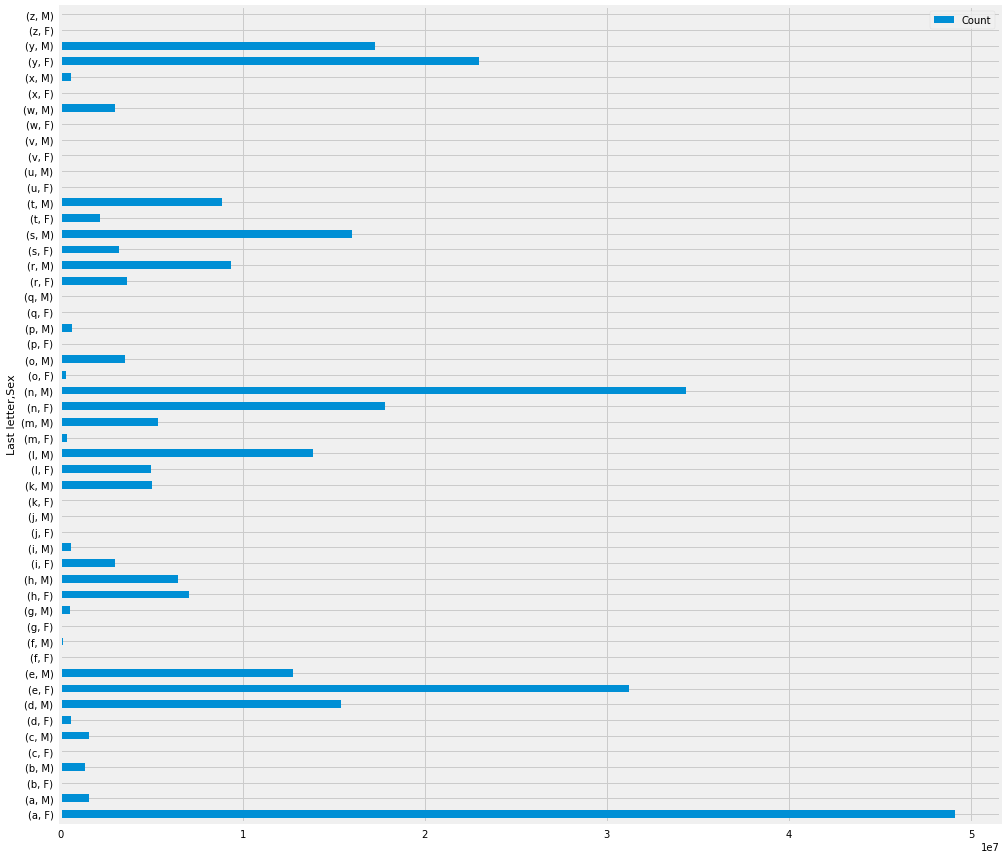

In [46]:
# Why is this not good?
letter_counts.plot.barh(figsize=(15, 15));

Reading the docs shows me that pandas will make one set of bars for each column in my table. How do I move each sex into its own column? I have to use pivot:

In [47]:
# For comparison, the group above:
# letter_counts = (baby_names
#                  .loc[:, ('Sex', 'Count', 'Last letter')]
#                  .groupby(['Last letter', 'Sex'])
#                  .sum())

last_letter_pivot = baby_names.pivot_table(
    index='Last letter', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)
last_letter_pivot.head()

Sex,F,M
Last letter,,
a,49128453,1585024
b,9666,1369244
c,18211,1565621
d,564804,15423771
e,31212081,12778932


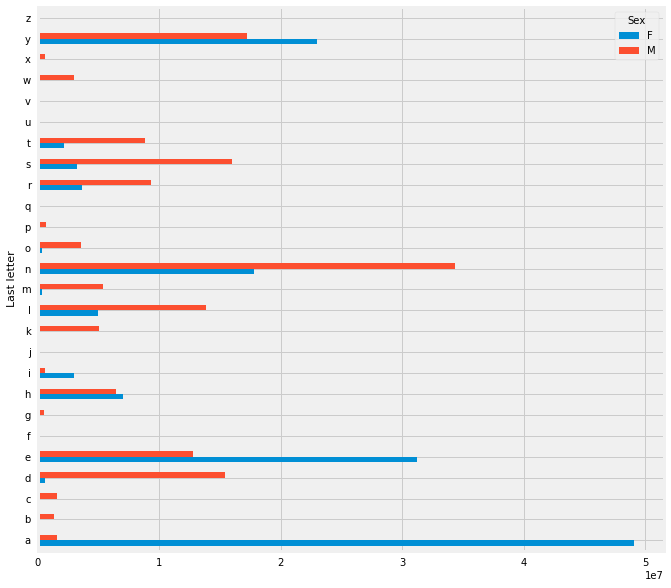

In [48]:
last_letter_pivot.plot.barh(figsize=(10, 10));

Why is this still not ideal?

- Plotting raw counts
- Not sorted by any order

In [49]:
totals = last_letter_pivot['F'] + last_letter_pivot['M']

last_letter_props = pd.DataFrame({
    'F': last_letter_pivot['F'] / totals,
    'M': last_letter_pivot['M'] / totals,
}).sort_values('M')
last_letter_props.head()

,F,M
Last letter,,
a,0.968746,0.031254
i,0.830335,0.169665
e,0.709510,0.290490
z,0.645210,0.354790
y,0.571341,0.428659


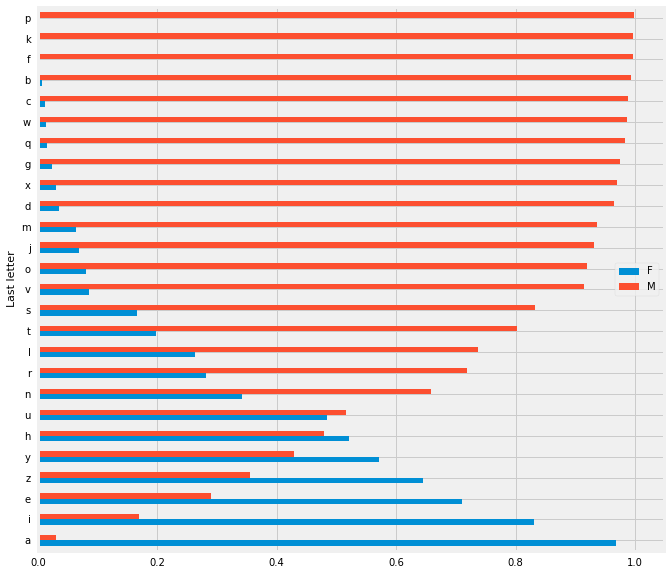

In [50]:
last_letter_props.plot.barh(figsize=(10, 10));

What do you notice?

## Seaborn

Let's use a subset of our dataset for now:

In [51]:
ca_and_ny = baby_names[
    (baby_names['Year'] == 2016)
    & (baby_names['State'].isin(['CA', 'NY']))
]
ca_and_ny.head()

,State,Sex,Year,Name,Count,Last letter
581101,CA,F,2016,Mia,2785,a
581102,CA,F,2016,Sophia,2747,a
581103,CA,F,2016,Emma,2592,a
581104,CA,F,2016,Olivia,2533,a
581105,CA,F,2016,Isabella,2350,a


We actually don't need to do any pivoting / grouping for seaborn!

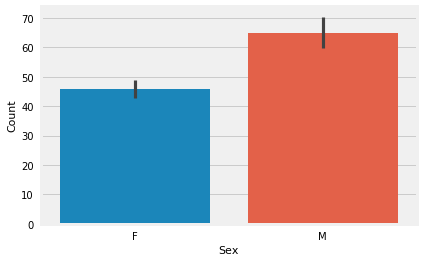

In [52]:
sns.barplot(x='Sex', y='Count', data=ca_and_ny);

Note the automatic confidence interval generation. Many seaborn functions have these nifty statistical features.

(It actually isn't useful for our case since we have a census. It also makes seaborn functions run slower since they use bootstrap to generate the CI, so sometimes you want to turn it off.)

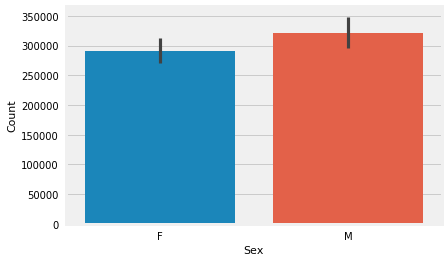

In [53]:
sns.barplot(x='Sex', y='Count', data=ca_and_ny, estimator=sum);

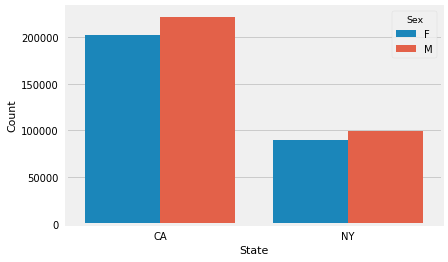

In [54]:
sns.barplot(x='State', y='Count', hue='Sex', data=ca_and_ny, ci=None, estimator=sum);

Going to work with tips data just to demonstrate:

In [55]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


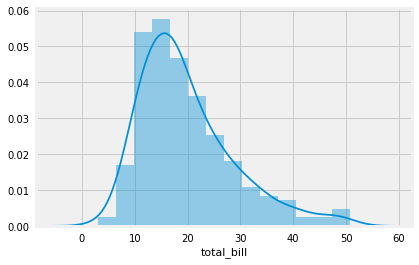

In [56]:
sns.distplot(tips['total_bill']);

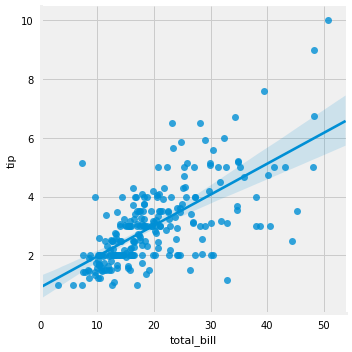

In [57]:
sns.lmplot(x="total_bill", y="tip", data=tips);

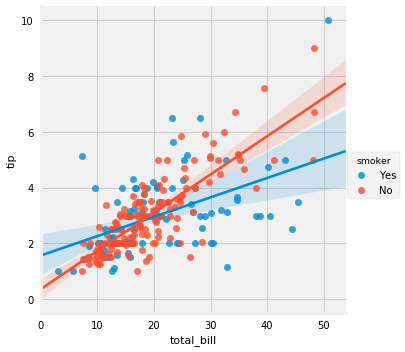

In [58]:
sns.lmplot(x="total_bill", y="tip", hue='smoker', data=tips);

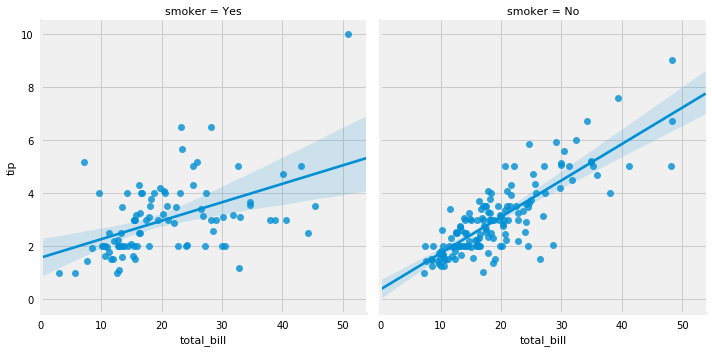

In [59]:
sns.lmplot(x="total_bill", y="tip", col="smoker", data=tips);